In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("Final-data.txt") #dosyadan okuma
data.head()

,Sports,Religious,Nature,Theatre,Shopping,Picnic
0,2,77,79,69,68,95
1,2,62,76,76,69,68
2,2,50,97,87,50,75
3,2,68,77,95,76,61
4,2,98,54,59,95,86


In [3]:
secilenData = data.loc[:,["Shopping","Nature"]]

In [4]:
secilenData.head()

,Shopping,Nature
0,68,79
1,69,76
2,50,97
3,76,77
4,95,54


In [5]:
A = secilenData.values

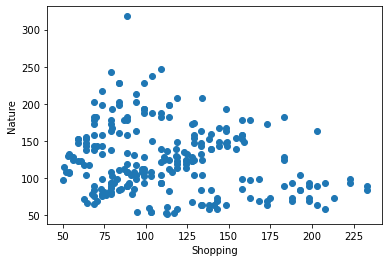

In [6]:
plt.scatter(A[:,0], A[:, 1])
plt.xlabel('Shopping')
plt.ylabel('Nature')
plt.show()

In [7]:
X = data.values # X verilerimiz

## K-means Algoritması

In [46]:
class Kmeans:
    def __init__(self,X,k):
        self.K = k # küme sayımız
        self.max_iterations = 3000 # hata durumu olursa sonsuza kadar dönmesin diye ekledim
        self.veriSayısı = X.shape[0]
        self.colonSayısı = X.shape[1]
        
    def rastgele_merkez(self,X):
        merkezler = np.zeros((self.K,self.colonSayısı))

        for i in range(self.K):
            merkez = X[np.random.choice(range(self.veriSayısı))] # rastgele merkez seçtik verilerimizden
            merkezler[i]=merkez

        return merkezler
    
    def kume_olustur(self,X,merkezler):
        kumeler = [[]for _ in range(self.K)] # K değeri kadar kume oluşturduk
        
        for index, veri in enumerate(X):
            enYakın_merkez = np.argmin(np.sqrt(np.sum((veri - merkezler) **2,axis=1))) # en yakın kume merkezini hesaplıyoruz

            kumeler[enYakın_merkez].append(index) #en yakın olduğu kümeye verinin indexini atıyoruz
            
        return kumeler
    
    
    def yeni_merkez_bul(self,kumeler,X):
        merkezler = np.zeros((self.K,self.colonSayısı))
        
        for index, kume in enumerate(kumeler):
            yeni_merkez = np.mean(X[kume],axis=0) #kumenin ortalamasını alarak yeni merkezi buluyoruz
            
            merkezler[index] = yeni_merkez
            
        return merkezler
    
    
    def kumeleme(self,kumeler,X):
        verilerin_kumeleri = np.zeros(self.veriSayısı)
        
        for kume_index, kume in enumerate(kumeler): #Veri indexine göre küme numaralarını atıyoruz
            for veri_index in kume:
                verilerin_kumeleri[veri_index] = kume_index
                
        return verilerin_kumeleri
    
    def durma_kosulu_2(self,verilerin_kumeleri,eski_verilerin_kumeleri):
        durdur = True
        for i in range(self.veriSayısı):
            if verilerin_kumeleri[i] != eski_verilerin_kumeleri[i]:
                durdur = False
                
        return durdur
    
    
    def fit(self,X):
        print("Kümeleme İşlemi Başladı...")
        merkezler = self.rastgele_merkez(X) #2. adım rastgele merkez seçiyoruz
        verilerin_kumeleri = np.zeros(self.veriSayısı)
        
        for i in range(self.max_iterations): #3. ve 4. adımı koşullar sağlanana kadar tekrarlıyoruz
            
            kumeler = self.kume_olustur(X,merkezler) #3. adım her veriyi en yakın kümeye atadık
            
            eski_merkezler = merkezler
            merkezler = self.yeni_merkez_bul(kumeler,X) #4. adım her kümenin yeni merkezini hesapladık
            
            merkezler_degisti = merkezler - eski_merkezler # durma koşulu 1 için eski merkezleri tutuyoruz
            
            eski_verilerin_kumeleri = verilerin_kumeleri # durma koşulu 2 için eski kümeleri tutuyoruz
            verilerin_kumeleri =self.kumeleme(kumeler,X)
            
            if not merkezler_degisti.any(): # durma koşulu
                print("Kume Merkezi Değişmedi Durma Koşulu Gerçekleşti...")
                break
            if self.durma_kosulu_2(verilerin_kumeleri,eski_verilerin_kumeleri) == True: # durma koşulu 2
                print("Hiçbir Veri Küme Değiştirmedi Durma Koşulu Gerçekleşti...")
                break
                
                # Hedeflenen SSE değerine ulaşılması çok mümkün olmadığı için o koşulu eklemedim
        
        
        wcss = self.wcss(X,merkezler) # wcss
        dunn_index = self.dunn_index(merkezler,X,kumeler) # dunn index
        tss = self.tss(X) # tss
        
        self.yazdir(kumeler,verilerin_kumeleri,wcss,tss,dunn_index) #Dosyaya yazdırdık
        
        print("Kümeleme İşlemi Tamamlandı. Dosyalarınız Hazır.")
        
        self.y = verilerin_kumeleri
        return verilerin_kumeleri
    
    
    def wcss(self,X,merkezler):
        wcss = [[]for _ in range(self.K)]
        for index, veri in enumerate(X):
            enYakın_merkez = np.argmin(np.sqrt(np.sum((veri - merkezler) **2,axis=1)))
            uzaklık = np.min(np.sum((veri - merkezler) **2,axis=1)) #uzaklığın karesi olamsı için direkt kök içine almadım
            wcss[enYakın_merkez].append(uzaklık)
        
        sonuc=0
        for i in range(self.K):
            sonuc += np.sum(wcss[i])
            
        return sonuc
    
    def tss(self,X):
        ortalama = np.mean(X,axis=0)
        tss=0
        for index, veri in enumerate(X):
            tss += np.sum((veri - ortalama) **2)
            
        return tss
    
    def dunn_index(self,merkezler,X,kumeler):
        min_inter_cd=float('inf')
        for i in range(self.K):
            for j in range(self.K):
                if i==j:continue
                uzaklık = np.sqrt(np.sum((merkezler[j] - merkezler[i]) **2))
                min_inter_cd = min(min_inter_cd,uzaklık)
            
        
        max_iter_cd=0
        for kume_index, kume in enumerate(kumeler):
            for veri_index in kume:
                for veri_index_2 in kume:
                    if veri_index == veri_index_2:continue
                    uzaklık2 = np.sqrt(np.sum((X[veri_index_2] - X[veri_index]) **2))
                    max_iter_cd = max(max_iter_cd,uzaklık2)
                    
        return min_inter_cd/max_iter_cd
                                  
    
    
    def plot(self,x_label,y_label): #görselleştirme
        #plt.scatter(X[:,2],X[:,5], c=y, s=40, cmap=plt.cm.Spectral)
        #plt.show()
        label = self.y
        u_labels = np.unique(label)
        for i in u_labels:
            plt.scatter(X[label == i,x_label],X[label == i,y_label], label=(f"Küme {int(i)}"),s=40)

        plt.xlabel(data.columns[x_label])
        plt.ylabel(data.columns[y_label])
        plt.legend()
        plt.show()
        
        
    def yazdir(self,kumeler,y,wcss,tss,dunn_index):
        dosya = open("sonuc_kumelere_gore.txt","w")
        dosya2= open("sonuc_verilere_gore.txt","w")
        
        for kume_index, kume in enumerate(kumeler):
            for veri_index in kume:
                dosya.write(f"Kayıt {veri_index}:   Kume {kume_index}\n")
                
        for i in range(y.size):
            dosya2.write(f"Kayıt {i}:    Kume: {int(y[i])}\n")
                
        for i in range(self.K):
            dosya.write(f"\nKüme {i}: {len(kumeler[i])} Kayıt")
            dosya2.write(f"\nKüme {i}: {len(kumeler[i])} Kayıt")
            
        dosya2.write(f"\n\nWCSS: {wcss}")
        dosya.write(f"\n\nWCSS: {wcss}")
        
        dosya2.write(f"\nBCSS: {tss-wcss}")
        dosya.write(f"\nBCSS: {tss-wcss}")
        
        dosya2.write(f"\nTSS: {tss}")
        dosya.write(f"\nTSS: {tss}")
        
        dosya2.write(f"\nDunn Index: {dunn_index}")
        dosya.write(f"\nDunn Index: {dunn_index}")
        
        dosya2.close()
        dosya.close()        

In [47]:
# Bu fonksiyonları eklemeseydim widgetlardan K değerini ve Labelları değiştirmek istediğimde class ın olduğu hücreyi 
# her seferinde shift+enter yapmam gerekiyordu pratik olsun diye ekledim

def fit(k,X):
    Kmeanss = Kmeans(X,k)
    Kmeanss.fit(X)
    return Kmeanss

def plot(K_means,x_label,y_label):
    K_means.plot(x_label,y_label)

# K değeri ve labellar için widget ekledim

In [48]:
import ipywidgets as widgets
k = widgets.IntText(
    value=3,
    description='K değeri:',
    disabled=False
)
x_label=widgets.Dropdown(
    placeholder='X labelı seç',
    value = 1,
    options=[('Sports',0), ('Religious',1), ('Nature',2), ('Theatre',3),('Shopping',4),('Picnic',5)],
    description='x_label:',
    ensure_option=True,
    disabled=False
)

y_label=widgets.Dropdown(
    placeholder='X labelı seç',
    value = 2,
    options=[('Sports',0), ('Religious',1), ('Nature',2), ('Theatre',3),('Shopping',4),('Picnic',5)],
    description='y_label:',
    ensure_option=True,
    disabled=False
)

### K değerini belirleyip fit ediyoruz.

In [49]:
k

IntText(value=3, description='K değeri:')

In [50]:
K_means=fit(k.value,X) # k_means

Kümeleme İşlemi Başladı...
Kume Merkezi Değişmedi Durma Koşulu Gerçekleşti...
Kümeleme İşlemi Tamamlandı. Dosyalarınız Hazır.


### X ve Y labellarını seçip çizdirebilirsiniz

In [51]:
x_label

Dropdown(description='x_label:', index=1, options=(('Sports', 0), ('Religious', 1), ('Nature', 2), ('Theatre',…

In [52]:
y_label

Dropdown(description='y_label:', index=2, options=(('Sports', 0), ('Religious', 1), ('Nature', 2), ('Theatre',…

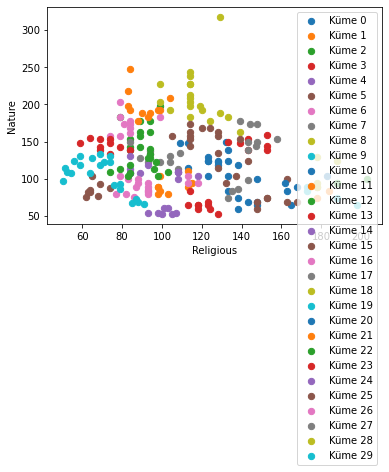

In [53]:
plot(K_means,x_label.value,y_label.value) # çizdirme fonksiyonu